In [ ]:
! pip install -q kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"aidsedsharoonjenishm","key":"0c2f0d4a5cdf6348977b4c7b84424191"}'}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [00:28<00:00, 145MB/s]
100% 2.29G/2.29G [00:28<00:00, 87.1MB/s]


In [ ]:
import zipfile
zf ="/content/chest-xray-pneumonia.zip"
target_dir = "/content/dataset/cnn/pneumonia_revamped"
zfile = zipfile.ZipFile(zf)
zfile.extractall(target_dir)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
train_path ="/content/dataset/cnn/pneumonia_revamped/chest_xray/train"
Test_path = "/content/dataset/cnn/pneumonia_revamped/chest_xray/test"
valid_path ="/content/dataset/cnn/pneumonia_revamped/chest_xray/val"

In [ ]:
batch_size =16
img_height = 500
img_width = 500

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
image_gen = ImageDataGenerator(
    rescale = 1./255,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
)

In [ ]:
test_data_gen = ImageDataGenerator(rescale = 1./255)

In [ ]:
train = image_gen.flow_from_directory(
    directory=r"/content/dataset/cnn/pneumonia_revamped/chest_xray/train",
    target_size=(img_height,img_width),
    color_mode ='grayscale',
    class_mode='binary',
    batch_size=batch_size
)

Found 5216 images belonging to 2 classes.


In [ ]:
test = test_data_gen.flow_from_directory(
    directory=r"/content/dataset/cnn/pneumonia_revamped/chest_xray/test",
    target_size=(img_height,img_width),
    color_mode ='grayscale',
    shuffle=False,
    class_mode='binary',
    batch_size=batch_size
)

Found 624 images belonging to 2 classes.


In [ ]:
valid = test_data_gen.flow_from_directory(
    directory=r"/content/dataset/cnn/pneumonia_revamped/chest_xray/val",
    target_size=(img_height,img_width),
    color_mode ='grayscale',
    class_mode='binary',
    batch_size=batch_size
)

Found 16 images belonging to 2 classes.


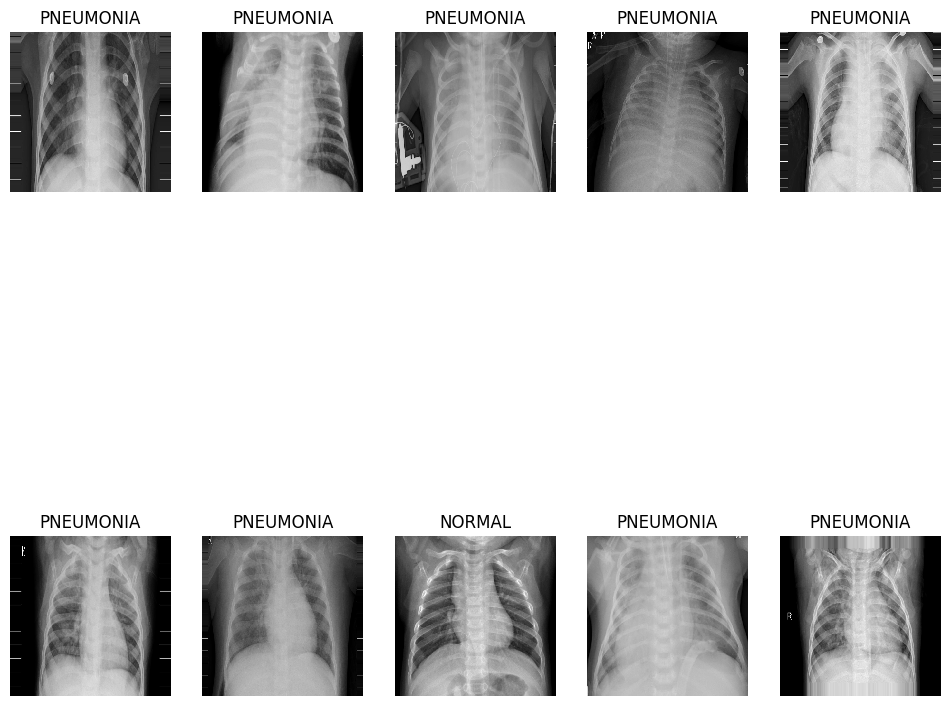

In [ ]:
plt.figure(figsize = (12,12))
for i in range(0,10):
  plt.subplot(2,5,i+1)
  for X_batch,Y_batch in train:
    image = X_batch[0]
    dic = {0:"NORMAL",1:"PNEUMONIA"}
    plt.title(dic.get(Y_batch[0]))
    plt.axis('off')
    plt.imshow(np.squeeze(image),cmap='gray',interpolation='nearest')
    break
    plt.tight_layout()
    plt.show()

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,Flatten,MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau

In [ ]:
cnn = Sequential()
cnn.add(Conv2D(32,(3,3),activation="relu", input_shape=(img_width,img_height,1)))
cnn.add(MaxPooling2D(pool_size =(2,2)))
cnn.add(Conv2D(32,(3,3),activation="relu", input_shape=(img_width,img_height,1)))
cnn.add(MaxPooling2D(pool_size =(2,2)))
cnn.add(Conv2D(32,(3,3),activation="relu", input_shape=(img_width,img_height,1)))
cnn.add(MaxPooling2D(pool_size =(2,2)))
cnn.add(Conv2D(64,(3,3),activation="relu", input_shape=(img_width,img_height,1)))
cnn.add(MaxPooling2D(pool_size =(2,2)))
cnn.add(Conv2D(64,(3,3),activation="relu", input_shape=(img_width,img_height,1)))
cnn.add(MaxPooling2D(pool_size =(2,2)))
cnn.add(Flatten())
cnn.add(Dense(activation = 'relu',units = 128))
cnn.add(Dense(activation = 'relu',units =64))
cnn.add(Dense(activation = 'sigmoid',units =1))
cnn.compile(optimizer ='adam',loss ='binary_crossentropy',metrics = ['accuracy'])

In [ ]:
cnn.summary()
model:"sequential 1"

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 498, 498, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 249, 249, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 247, 247, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 123, 123, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 121, 121, 32)      9248      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 60, 60, 32)        0

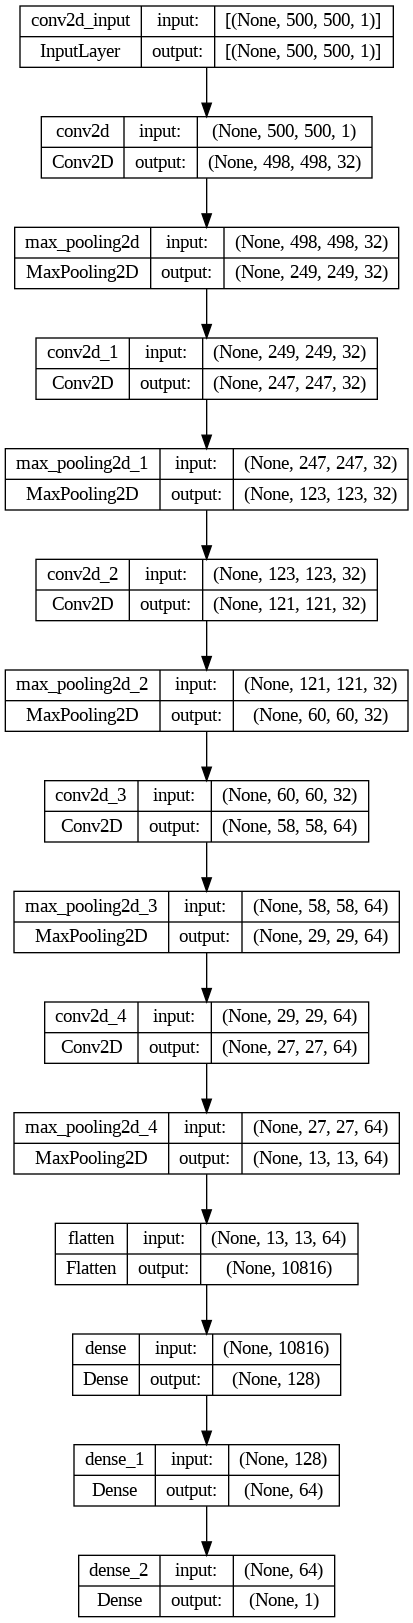

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(cnn,show_shapes=True, show_layer_names=True,rankdir='TB',expand_nested=True)

In [ ]:
early = EarlyStopping(monitor="val_loss",mode="nin", patience=3)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience = 2, vetbose=1,factor=0.3,nin_lr=0.00001)
callbacks_list = [early,learning_rate_reduction]

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
y=np.stack(train.classes)
classes=np.unique(train.classes)
weights = compute_class_weight('balanced',classes=classes,y=y)
cw = dict(zip(np.unique(train.classes), weights))
print(cw)

{0: 1.9448173005219984, 1: 0.6730322580645162}


In [ ]:
cnn.fit(train,epochs=25,validation_data=valid, class_weight=cw, callbacks=callbacks_list)

Epoch 1/25
326/326 [==============================] - 942s 3s/step - loss: 0.4008 - accuracy: 0.7885 - val_loss: 0.8140 - val_accuracy: 0.6875 - lr: 0.0010
Epoch 2/25
326/326 [==============================] - 948s 3s/step - loss: 0.2263 - accuracy: 0.9103 - val_loss: 0.8379 - val_accuracy: 0.6875 - lr: 0.0010
Epoch 3/25
326/326 [==============================] - 941s 3s/step - loss: 0.1975 - accuracy: 0.9189 - val_loss: 0.5685 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 4/25
239/326 [====================>.........] - ETA: 4:12 - loss: 0.1941 - accuracy: 0.9210

<Axes: >

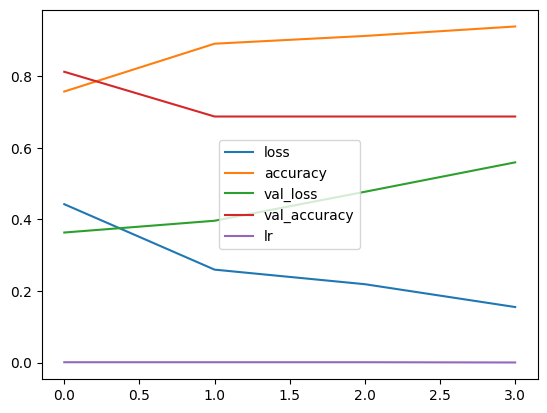

In [ ]:
pd.DataFrame(cnn.history.history).plot()

In [ ]:
test_accu = cnn.evaluate(test)
print('The testing accuracy is ;',test_accu[1]*100, '%')

39/39 [==============================] - 33s 822ms/step - loss: 0.2589 - accuracy: 0.8958
The testing accuracy is ; 89.58333134651184 %


In [ ]:
preds = cnn.predict(test,verbose=1)
predictions = preds.copy()
predictions[predictions <= 0.5] = 0
predictions[predictions > 0.5] = 1

39/39 [==============================] - 33s 825ms/step


<Axes: >

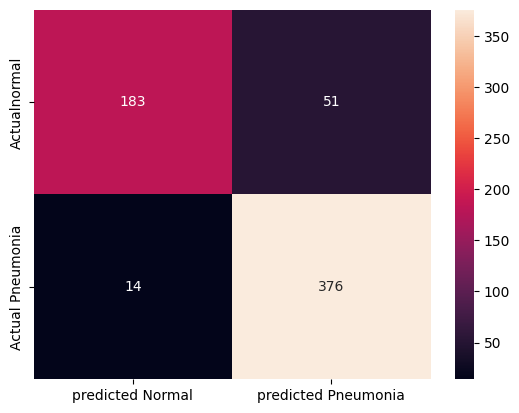

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix
cm = pd.DataFrame(data=confusion_matrix(test.classes,predictions,labels=[0,1]),index=["Actualnormal","Actual Pneumonia"],
columns=["predicted Normal","predicted Pneumonia"])
import seaborn as sns
sns.heatmap(cm, annot=True,fmt="d")


In [ ]:
print(classification_report(y_true=test.classes,y_pred=predictions,target_names =['NORMAL','PHEUMONIA']))

              precision    recall  f1-score   support

      NORMAL       0.93      0.78      0.85       234
   PHEUMONIA       0.88      0.96      0.92       390

    accuracy                           0.90       624
   macro avg       0.90      0.87      0.88       624
weighted avg       0.90      0.90      0.89       624



1/1 [==============================] - 0s 59ms/step


/usr/local/lib/python3.10/dist-packages/matplotlib/axes/_base.py:1918: RuntimeWarning: divide by zero encountered in double_scalars
  fig_aspect = bb.height / bb.width
/usr/local/lib/python3.10/dist-packages/matplotlib/_tight_bbox.py:64: RuntimeWarning: divide by zero encountered in double_scalars
  fig.patch.set_bounds(x0 / w1, y0 / h1,
/usr/local/lib/python3.10/dist-packages/matplotlib/_tight_bbox.py:65: RuntimeWarning: divide by zero encountered in double_scalars
  fig.bbox.width / w1, fig.bbox.height / h1)
/usr/local/lib/python3.10/dist-packages/matplotlib/patches.py:738: RuntimeWarning: invalid value encountered in double_scalars
  x1 = self.convert_xunits(self._x0 + self._width)
/usr/local/lib/python3.10/dist-packages/matplotlib/transforms.py:2041: RuntimeWarning: invalid value encountered in double_scalars
  self._mtx[0, 2] += tx


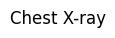

I am (:.2%) percent confirmed that this is not a pneumonia case


In [ ]:
image_path=r'/content/dataset/cnn/pneumonia_revamped/chest_xray/test/NORMAL/IM-0001-0001.jpeg'
from tensorflow.keras.preprocessing import image
own_img = image.load_img(image_path,target_size=(500,500),color_mode='grayscale')
pp_own_img=image.img_to_array(own_img)
pp_own_img=pp_own_img/255
pp_own_img=np.expand_dims(pp_own_img, axis=0)
owns_preds=cnn.predict(pp_own_img)
plt.figure(figsize=(0,6))
plt.axis('off')
if owns_preds >=0.5:
    out = ("I am (:.2%) percent confirmed that this is a pneumonia case".format(owns_preds[0][0]))
else:
    out = ("I am (:.2%) percent confirmed that this is not a pneumonia case".format(1-owns_preds[0][0]))

plt.title("Chest X-ray")
plt.imshow(np.squeeze(pp_own_img), cmap='gray')
plt.show()

print(out)